In [268]:
"""Analysis framework for checking samples from probability distributions

(1) Features (including proximity value) are calculated
(2) Classifiers are trained (RF)
(3) Permutation feature importance is calculated and fitted with an exponential function.

"""

from numpy import array, linspace, tile, \
                    count_nonzero, zeros, divide, \
                    logical_and, copy, stack

import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform, pdist

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier as RF

class Population:
    
    def __init__(self, state, locs, n, mDist=array([])):
        self.N = state.size
        self.state = copy(state)
        self.locs = copy(locs)
        self.n = n
        self.features = dict()
        
        if mDist.shape != (self.N, self.N):
            self.mDist = squareform(pdist(locs))
        else:
            self.mDist = mDist
        
    def density(self):
        int_state = array(self.state, dtype='int32')
        return sum(int_state) * 1.0 / self.N

    def show(self):
        # add figure
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111)
        
        
        cells = self.locs[self.state == True]
        empty = self.locs[self.state == False]

        ax.scatter(cells[:,0], cells[:,1], color='green', s= 10, alpha=0.5)
        ax.scatter(empty[:,0], empty[:,1], color='red', s=10, alpha=0.5)
        
        return fig, ax
    
    def init_features(self, rmin, rmax, nr):
        """
        Calculate density for given area with radius r.
        
        """
        # init the radii
        self.features = dict()
        radii = linspace(rmin, rmax, num=nr, endpoint=True)
        
        # helper for calculating density gains
        mState = tile(self.state, (self.N, 1))
        previous_density = zeros(self.N)
        
        for radius in radii:
            loc_in_range = self.mDist < radius
            mCells = logical_and(mState, loc_in_range)
        
            n_cells = count_nonzero(mCells, axis=1)
            n_locs = count_nonzero(loc_in_range, axis=1) # symmetric, which axis doesn't matter
            density = divide(n_cells, n_locs)
            
            density_gain = density - previous_density
            
            self.features[radius] = density_gain
            
            previous_density = density
        
    def analyse(self):
        """
        Train Random Forest and compute feature importance.
        """
        
        # prepare data
        data = stack(list(self.features.values()), axis=1)
        targets = self.state
        
        X_train, X_test, y_train, y_test = train_test_split(
            data, targets, random_state=0)
    
        n_est = 100
        model = RF(n_estimators=n_est).fit(X_train, y_train)
    
        # output
        print("Trained Random Forest with n_est=%d." % n_est)
        print("--- Test Sample Size: \t %d" % y_test.size)
        print("--- Train Sample Size: \t %d" % y_train.size)
        print("\n--> Score: \t %.2f" % model.score(X_test, y_test))
    
        # calculate importances
        imp = permutation_importance(
            model, X_test, y_test,
            n_repeats=10, random_state=0, scoring='roc_auc')
        
        
        
        return imp.importances_mean, imp.importances_std
    

Real inital desity n_i = 0.0061

At step 100 -> Population saved with n = 0.021

At step 125 -> Population saved with n = 0.030

At step 150 -> Population saved with n = 0.044

At step 175 -> Population saved with n = 0.062

At step 200 -> Population saved with n = 0.086

At step 225 -> Population saved with n = 0.117

At step 250 -> Population saved with n = 0.154

At step 275 -> Population saved with n = 0.206

At step 300 -> Population saved with n = 0.265

At step 325 -> Population saved with n = 0.335

At step 350 -> Population saved with n = 0.415

At step 375 -> Population saved with n = 0.497

At step 400 -> Population saved with n = 0.579

At step 425 -> Population saved with n = 0.652

At step 450 -> Population saved with n = 0.718

At step 475 -> Population saved with n = 0.781

At step 500 -> Population saved with n = 0.825

At step 525 -> Population saved with n = 0.863

At step 550 -> Population saved with n = 0.891

At step 575 -> Population saved with n = 0.914

Elapsed

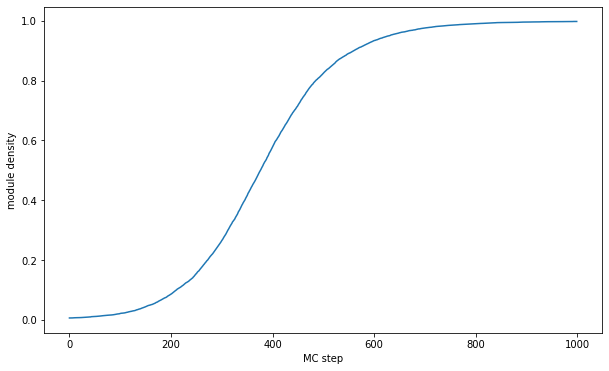

In [404]:
"""Simple Proximity Dynamics Model.

Model the network dynamics of solar panel installation
by assuming panel proximity as the main determining variable.

"""
from time import time

from numpy import array, dot, exp
from numpy.random import rand, seed
from scipy.spatial.distance import pdist, squareform

import matplotlib.pyplot as plt

# model parameters
#
# all distances are normalized by r0 = 210 m
# i.e. r = 20 corresponds to r_real = 210 * 20 = 4.2 km

# area under test L^2
L = 20

# number of addresses
N = 10000

# initial panel density
n0 = 0.005

seed(0)

# create pseudo-random locations
locs = rand(N, 2) * L
all_dist = squareform(pdist(locs))

# initial state
state = rand(N) < n0

def density(state): # state: boolean 1-D array
    int_state = array(state, dtype='int32')
    return sum(int_state) * 1.0 / N

n_real = density(state)

print("Real inital desity n_i = %.4f\n" % n_real)

exp_all_dist = exp(-all_dist)

def mc_step(locs, state):
    #
    # iterate over all locations
    # and update with weight exp(-d_r)
    
    rnds = rand(N) * N
    
    for i, panel in enumerate(state):
        if not panel:       
            p = dot(exp_all_dist[i], state)
            state[i] = p > rnds[i]

# save some populations and densities 
# for visualizing and further analysis
densities = []
populations = []

#----------------
# run simulation
#----------------
n_steps = 1000
tStart = time()

for step in range(n_steps):
    mc_step(locs, state)
    n = density(state)
    densities.append(n)
    
    if step >= 100 and step < 600 \
        and step % 25 == 0:
            # print information
            print("At step %d -> Population saved with n = %.3f\n" % (step, n))
            populations.append(Population(state, locs, n, mDist=all_dist))

elapsed = time() - tStart
print("Elapsed time %f" % elapsed)
    
fig = plt.figure(figsize=(10, 6))
plt.plot(densities)
plt.xlabel('MC step')
plt.ylabel('module density')
plt.show()


Population analysis n=0.258


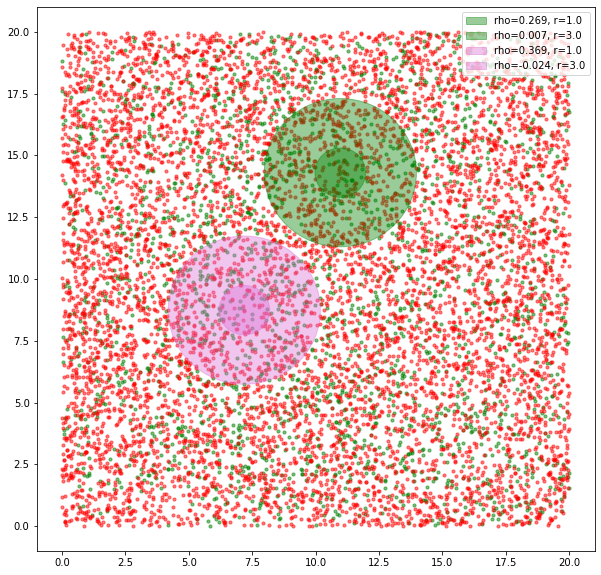

In [270]:
"""
--------------------------------
Analysis of the populations (I)
--------------------------------

Visualization the data and the feature calculation.

"""
import matplotlib.pyplot as plt

# analyse first population
p = populations[0]
print("Population analysis n=%.3f" % p.density())
    
# First, calculate the features
# -> density gain within given radius
rmin = 1.0
rmax = 3.0
nr = 2
p.init_features(rmin, rmax, nr)


# add figure
fig, ax = p.show()

# visualize feature for some indices
# choosed by hand (because of centered location)
indices = [0, 20]
colors = ['green', 'orchid']

circles, labels = [], []
for idx, c in zip(indices, colors):
    
    x, y = p.locs[idx]
    
    for r in linspace(rmin, rmax, nr):
        circle = plt.Circle((x, y), r, color=c, alpha=0.4)
    
        circles.append(circle)
        labels.append('rho=%.3f, r=%.1f' % (p.features[r][idx], r))
    
        ax.add_patch(circle)

ax.legend(circles, labels)

plt.show()


Population analysis n=0.021
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.98
--> r0 = 0.521 +\- 0.113
--> a = 0.255 +\- 0.065


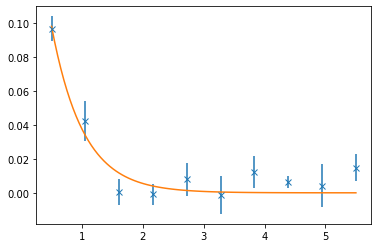


Population analysis n=0.030
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.97
--> r0 = 0.534 +\- 0.199
--> a = 0.341 +\- 0.148


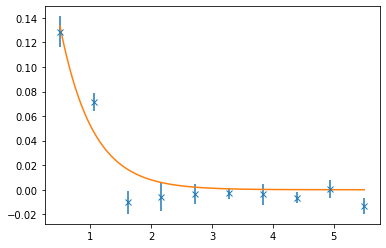


Population analysis n=0.044
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.95
--> r0 = 0.634 +\- 0.209
--> a = 0.248 +\- 0.087


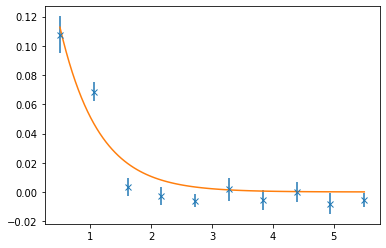


Population analysis n=0.062
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.94
--> r0 = 0.469 +\- 0.066
--> a = 0.361 +\- 0.064


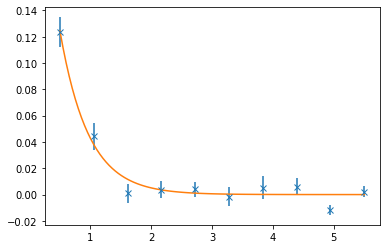


Population analysis n=0.086
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.91
--> r0 = 0.337 +\- 0.015
--> a = 0.529 +\- 0.038


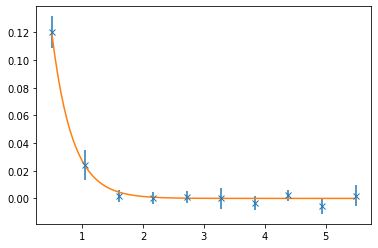


Population analysis n=0.117
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.88
--> r0 = 0.405 +\- 0.088
--> a = 0.393 +\- 0.117


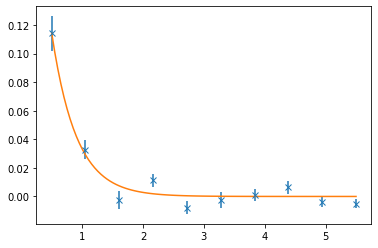


Population analysis n=0.154
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.84
--> r0 = 0.241 +\- 0.079
--> a = 0.902 +\- 0.629


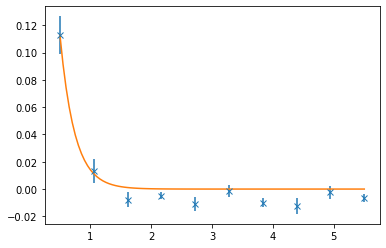


Population analysis n=0.206
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.78
--> r0 = 0.222 +\- 0.066
--> a = 1.125 +\- 0.765


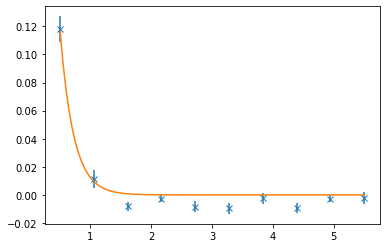


Population analysis n=0.265
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.72
--> r0 = 0.274 +\- 0.058
--> a = 0.718 +\- 0.284


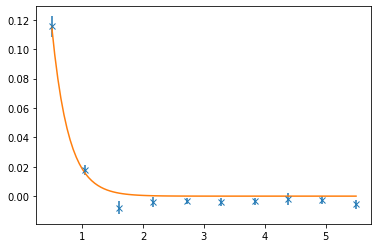


Population analysis n=0.335
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.66
--> r0 = 0.229 +\- 0.040
--> a = 1.046 +\- 0.400


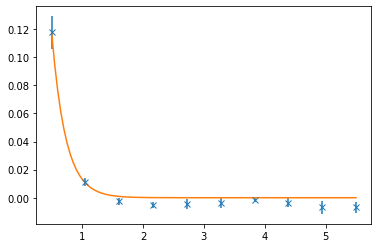


Population analysis n=0.415
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.62
--> r0 = 0.330 +\- 0.062
--> a = 0.384 +\- 0.117


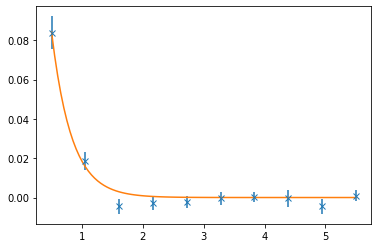


Population analysis n=0.497
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.61
--> r0 = 0.184 +\- 0.089
--> a = 1.419 +\- 1.879


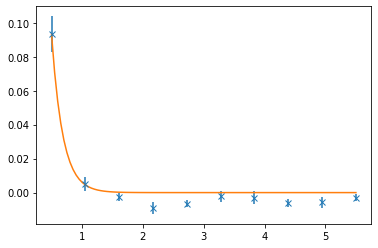


Population analysis n=0.579
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.63
--> r0 = 0.182 +\- 0.042
--> a = 1.407 +\- 0.889


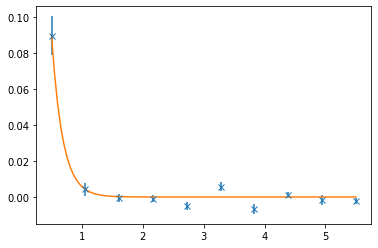


Population analysis n=0.652
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.70
--> r0 = 0.358 +\- 0.047
--> a = 0.315 +\- 0.062


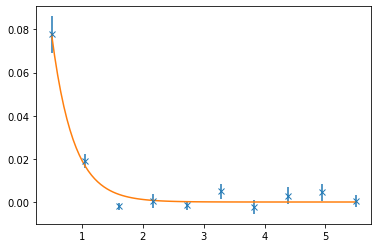


Population analysis n=0.718
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.72
--> r0 = 0.349 +\- 0.055
--> a = 0.352 +\- 0.086


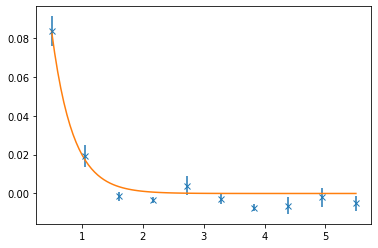


Population analysis n=0.781
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.79
--> r0 = 0.429 +\- 0.062
--> a = 0.268 +\- 0.051


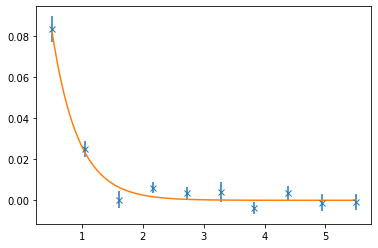


Population analysis n=0.825
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.83
--> r0 = 0.473 +\- 0.076
--> a = 0.238 +\- 0.048


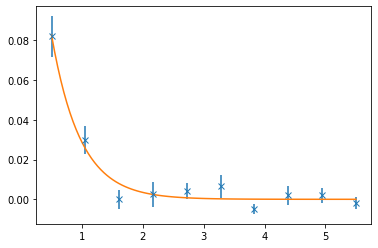


Population analysis n=0.863
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.86
--> r0 = 0.459 +\- 0.070
--> a = 0.238 +\- 0.046


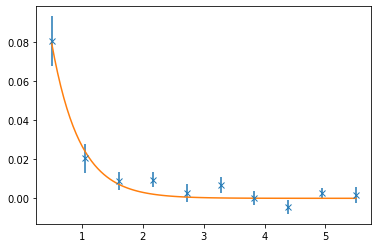


Population analysis n=0.891
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.89
--> r0 = 0.685 +\- 0.089
--> a = 0.174 +\- 0.023


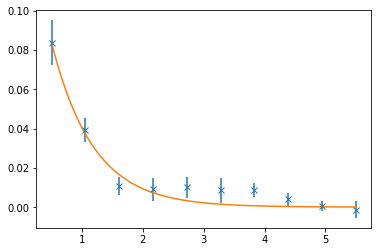


Population analysis n=0.914
Trained Random Forest with n_est=100.
--- Test Sample Size: 	 2500
--- Train Sample Size: 	 7500

--> Score: 	 0.92
--> r0 = 0.608 +\- 0.114
--> a = 0.183 +\- 0.037


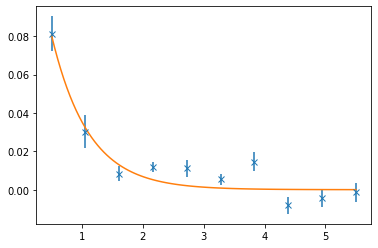

In [405]:
"""
--------------------------------
Analysis of the populations (II)
--------------------------------


"""
import numpy as np

from numpy import exp, inf
from scipy.optimize import minimize, Bounds, curve_fit

import matplotlib.pyplot as plt

# init parameters for feature calculation
rmin = 0.5
rmax = 5.5
nr = 10

def model(x, a, r0):
    return a * np.exp(- x / r0)

def run_analysis(p):
    print("\nPopulation analysis n=%.3f" % p.density())
    p.init_features(rmin, rmax, nr)
    
    mean, std = p.analyse()
    
    # fit exp function to data
    x0 = array([0.0, 0.1])
    bnds = (array([-inf, 0.0]), array([inf, inf]))
    nmax = 5
    popt, pcov = curve_fit(model, array(list(p.features.keys())[:nmax]), mean[:nmax], p0=x0, bounds=bnds)
    
    #result = minimize(chi2, x0, args=(mean[:], array(list(p.features.keys())[:]), std[:]))
    
    # output
    #print("\nSolver terminated successfully with nit=%d" % result.nit)
    perr = np.sqrt(np.diag(pcov))
    print("--> r0 = %.3f +\- %.3f" % (popt[1], perr[1]))
    print("--> a = %.3f +\- %.3f" % (popt[0], perr[0]))
    #print("--> b = %.3f" % result.x[2])
    
    # plot result
    fig = plt.figure()
    plt.errorbar(p.features.keys(), mean, yerr=std, fmt='x')
    
    xs = np.linspace(rmin, rmax, 100)
    plt.plot(xs, model(xs, *popt))
    plt.show()

#################################################
# Population I
# 
for population in populations:
    run_analysis(population)
#run_analysis(populations[1])
#run_analysis(populations[2])
#run_analysis(populations[3])

